## Basic segmentation
### Installing omero-py


In [ ]:
!pip install omero-py https://github.com/glencoesoftware/zeroc-ice-py-linux-x86_64/releases/download/20240202/zeroc_ice-3.6.5-cp311-cp311-manylinux_2_28_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 39.7 MB/s eta 0:00:00


### Calling required libraries

In this notebook, we are utilizing several powerful Python libraries for data manipulation, image processing, scientific computing, and machine learning. Below is an introduction to each of these libraries and their key functionalities:

1. **omero-py** is a Python client library for OMERO (Open Microscopy Environment Remote Objects), a platform for managing, visualizing, and analyzing large-scale microscopy image datasets. omero-py allows users to interact with an OMERO server programmatically, enabling image uploads, metadata management, and advanced data analysis workflows.
2. **NumPy** is a fundamental package for scientific computing in Python. It provides support for large multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
3. **Matplotlib** is a plotting library used for creating static, interactive, and animated visualizations in Python. It is particularly useful for generating plots, histograms, bar charts, and other types of visualizations.
4. **Pandas** is a powerful data manipulation and analysis library. It provides data structures like DataFrames, which are essential for handling and analyzing structured data.
5. **SciPy** is a library used for scientific and technical computing. It builds on NumPy and provides a large number of higher-level functions that are useful for different types of scientific and engineering applications, such as optimization, integration, interpolation, and image processing.
6. **OpenCV (cv2)** is an open-source computer vision and image processing library. It provides a wide range of functions for image and video processing, including reading and writing images, filtering, edge detection, and object detection.
7. **scikit-image (skimage)** is a collection of algorithms for image processing. It is built on top of NumPy and is designed to work with other scientific computing libraries. It provides functions for image filtering, morphology, segmentation, and feature extraction.
8. **scikit-learn (sklearn)** is a machine learning library that provides simple and efficient tools for data mining and data analysis. It includes a wide range of algorithms for classification, regression, clustering, and dimensionality reduction, as well as tools for model selection and evaluation.


These libraries together provide a comprehensive toolkit for handling and analyzing data, processing images, and applying machine learning techniques.

In [ ]:
%matplotlib inline
from omero.gateway import BlitzGateway
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi

import cv2

# presprocessing
import skimage.filters
from skimage.exposure import rescale_intensity

#morphology
from skimage import measure
import skimage.morphology
from skimage.measure import label, regionprops_table

# import threshold and gray convertor functions
from skimage.color import rgb2gray, label2rgb

# for watershed implementation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from sklearn.cluster import KMeans


In [ ]:
# function to show image
def show_image(image, cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.axis('off')
    plt.show()

### 1. Fetching data from OMERO server
First we will read an image file and do some processing. OpenCV read images in BGR format by default, therefore we will convert its color format from BRG to RGB and display it using Matplotlib.

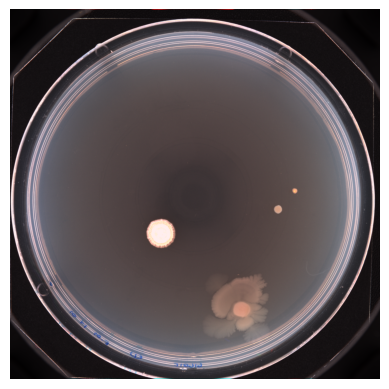

In [ ]:
conn = BlitzGateway('daniela', 'workshop2025',
                        host='omero.scilifelab.se', secure=True)
conn.connect()
conn.c.enableKeepAlive(60)

image_id = 302
image_obj = conn.getObject("Image", image_id)

# Get the raw pixel data
pixels = image_obj.getPrimaryPixels()
channels = []
for c in range(image_obj.getSizeC()):
    plane = pixels.getPlane(0, c, 0)  # z, c, t indices
    channels.append(plane)

# stack the channels to create a color image
image_color = np.stack(channels, axis=-1)
# rescale the intensity of the image to the range [0, 255]
image_color = rescale_intensity(image_color, in_range='image', out_range=(0, 255)).astype(np.uint8)

# get grayscale image
image_gray = pixels.getPlane(0, 0, 0)  # z, c, t indices

# Display the color image using matplotlib
show_image(image_color)

conn.close()

Next, we convert the RGB image to grayscale and adjust the intensity by removing the percentile 10th and 90th (extreme values) from the range.

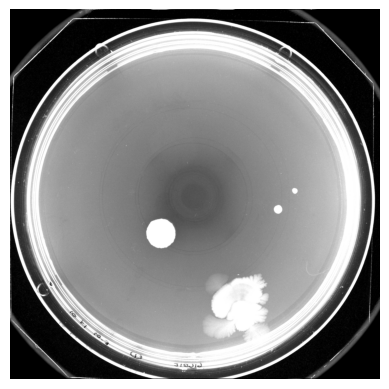

In [ ]:
p10, p90 = np.percentile(image_gray, (10,90))
image_rescaled = rescale_intensity(image_gray, in_range=(p10, p90))
# rescale the intensity of the image to the range [0, 1]
image_rescaled = image_rescaled / 65535.0
show_image(image_rescaled)

#### 2. Mask and segmentation
We are going to create a mask to remove the area outside of the plate. We define a center coordinates and radius and apply it to the grayscale image.

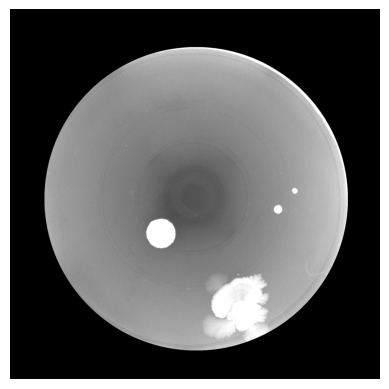

In [ ]:
imageSize = image_rescaled.shape
ci = [1030, 1050, 840]
# generate grid same size as the original image
x = np.arange(0,imageSize[0])-ci[0]
y = np.arange(0,imageSize[1])-ci[1]
xx, yy = np.meshgrid(x, y)
# generate mask
mask = (xx**2 + yy**2) < ci[2]**2
# turn mask into integer
mask = mask.astype(int)
rgbI_mask=mask*image_rescaled
show_image(rgbI_mask)

To be able to segment our bacterial colonies, we plot the intensity values. We will use to different thresholds to be able to segment bacteria colonies with a bright color and bacteria colonies with a dark color.

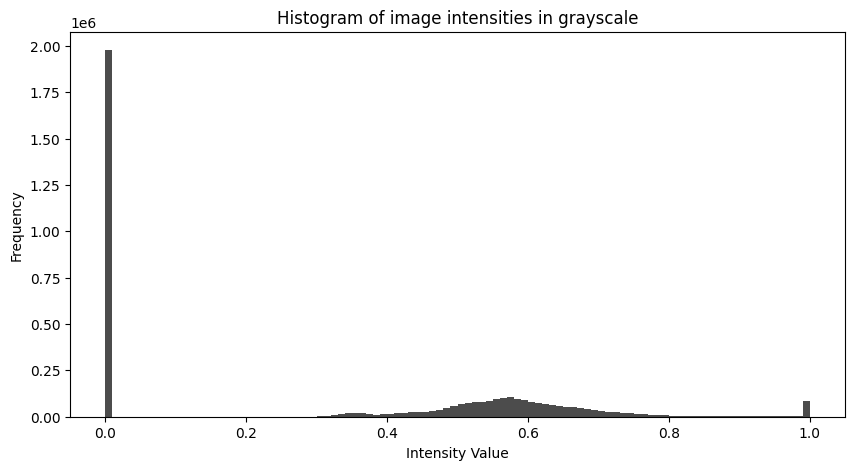

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(rgbI_mask.ravel(), bins=100, color='black', alpha=0.7)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.title('Histogram of image intensities in grayscale')
plt.show()

From the mask grayscale image, we identified the bright colonies by applying a thresholding at the arbitrary value of > than 0.8 and performing an area closing operation to fill small holes within the colonies.

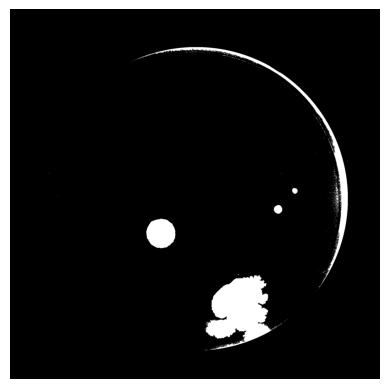

In [ ]:
image_threshold_bright = rgbI_mask >= 0.80
image_area_closing = skimage.morphology.area_closing(image_threshold_bright, area_threshold=100)
binary_image_bright = image_area_closing
show_image(binary_image_bright)

Next, we identified the dark colonies by applying a thresholding at between the values 0.1 and 0.25. We again do an area closing operation to fill small holes within the colonies.

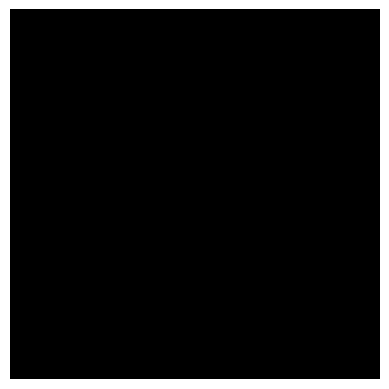

In [ ]:
image_threshold_dark = (rgbI_mask > 0.1) & (rgbI_mask < 0.25)
image_area_closing = skimage.morphology.area_closing(image_threshold_dark, area_threshold=100)
binary_image_dark = image_area_closing
show_image(binary_image_dark)

We combine both thresholding outputs to collect bright and dark colonies in a single binary image.

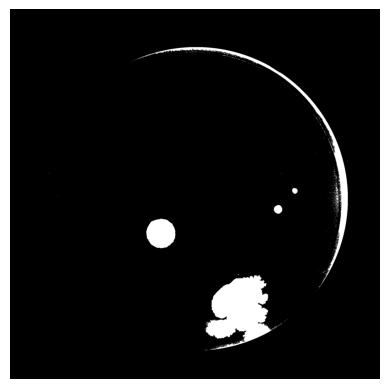

In [ ]:
binary_image = (binary_image_bright + binary_image_dark) * mask
show_image(binary_image)

#### 3. Extract information from regions
To extract the information from each segmented object we use the label() function and the we analyse the properties in the labelled regions. The function labels connected components in the binary image, assigning a unique label to each connected region. The resulting image_labeled is an image where each pixel value correspondos to the label of the region it belongs.

In [ ]:
# label image for mapping
image_labeled = label(binary_image)
# analyze regions
regions = regionprops_table(image_labeled, intensity_image=image_rescaled, properties = ('label','centroid', 'area', 'perimeter',
'equivalent_diameter', 'eccentricity', 'convex_area', 'mean_intensity'))

We implement a processing and filtering step to remove segmented objects that might not be bacteria colonies. We do a two step processing. The first step filters the regions based on their size and shape, selecting an area in between 60 - 500000 and an eccentricity (how rounded is an object) less than 0.8. T
The second filtering step involves removing colonies that are near or outside the border of the plate. This is done by fitting a circle to each region and checking if the circle lies within specified boundaries (200 to 1845 in both x and y directions). The code iterates through each region, calculates the circle's coordinates, and checks if all points of the circle are within the boundaries. If a region passes this check, its index is added to the `idx` list, and a unique label is assigned and stored in `label_ID`. Next, the code generates unique labels for each filtered region by combining a base name with the region's unique label. These labels are stored in the `name_label` list.

In [ ]:
# turn into data frame for easy access
df = pd.DataFrame(regions)

# Filter in two steps
# filter first by size and sape
data_region = df.loc[(df['area']>60) & (df['area']<500000) & (df['eccentricity'] < 0.8)]
# filter second position on the plate
# calculate indexes to plot a circle and compare with the indexes in mask to remove colonies near or outside the border.
idx = []
label_ID = []
j = 1
th = np.arange(0,2*np.pi,np.pi/5)
for i in range(data_region.shape[0]):
    # fit a circle
    xunit = data_region.iloc[i][5]/2 * np.cos(th) + data_region.iloc[i][1]
    yunit = data_region.iloc[i][5]/2 * np.sin(th) + data_region.iloc[i][2]
    # find within the boundaries. Check ci variable
    y1 = np.array(yunit>200)
    y2 = np.array(yunit<1845)
    x1 = np.array(xunit>200)
    x2 = np.array(xunit<1845)
    xy = y1 & y2 & x1 & x2
    mean_xy = np.mean(np.multiply(xy, 1))
    if mean_xy == 1:
        idx.append(i)
        label_ID.append(j)
        j = j + 1
# filtered data frame
data_regions_filtered = data_region.iloc[idx]
data_regions_filtered.reset_index(drop=True, inplace=True)
data = data_regions_filtered[data_regions_filtered.columns[1:]]
name_label = []
for i in range(data.shape[0]):
    label_str = str(label_ID[i])
    name_label.append(str(image_id)+'_'+label_str)

temp_df = {'unique_label':name_label, 'label':label_ID}
name_df = pd.DataFrame(data=temp_df)
data_label = pd.concat([name_df, data], axis=1)
data_label


<ipython-input-12-58f97de9c463>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xunit = data_region.iloc[i][5]/2 * np.cos(th) + data_region.iloc[i][1]
<ipython-input-12-58f97de9c463>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yunit = data_region.iloc[i][5]/2 * np.sin(th) + data_region.iloc[i][2]


,unique_label,label,centroid-0,centroid-1,area,perimeter,equivalent_diameter,eccentricity,convex_area,mean_intensity
0,302_1,1,1005.950993,1576.245033,755.0,103.497475,31.004772,0.416011,784.0,0.987324
1,302_2,2,1108.553364,1483.571346,1724.0,153.438600,46.851521,0.206293,1758.0,0.991391
2,302_3,3,1241.735346,834.921811,20540.0,543.872150,161.716852,0.188053,20861.0,0.997909
3,302_4,4,1666.228395,1271.345194,91447.0,3134.984161,341.224174,0.562432,114009.0,0.956767


#### 4. Map the colonies in plate
We finalised the colonia identification by viualising labeled regions on the original image by drawing circles and labels, and then resizing the image for display.

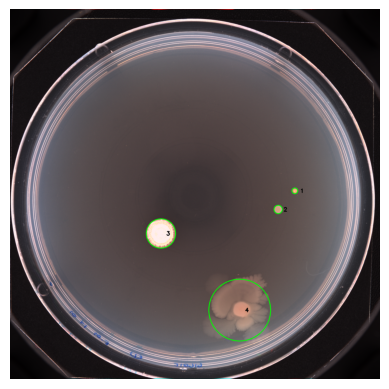

In [ ]:
# make a copy of the original image
img = image_color.copy()
for i in range(data_label.shape[0]) :
    # draw circle
    cv2.circle(img,(round(data_label['centroid-1'][i]), round(data_label['centroid-0'][i])), round(data_label['equivalent_diameter'][i]/2), (0,255,0), 3)
    # draw text, label
    cv2.putText(img, str(data_label['label'][i]), (round(data_label['centroid-1'][i]+30), round(data_label['centroid-0'][i]+10)), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (1, 1, 1), 4)

# new width and height to resize the image
scale = 50
width = int(img.shape[1] * scale/100)
height = int(img.shape[0] * scale/100)

# resizing the image
resized_img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

show_image(resized_img)


#### Extra: Testing watershed
The watershed algorithm is a popular image segmentation technique used to separate different objects in an image it treats the imake like a topographic map with valleys and peaks. First a distance transform is applied to the binary image, calculating the distance from each pixel ro the nearest background pixel (0), creating a distance map where the peaks are the centers of the objects which are set as markers. Then, the watershed algorith segments the image.

Text(0.5, 1.0, 'BW')

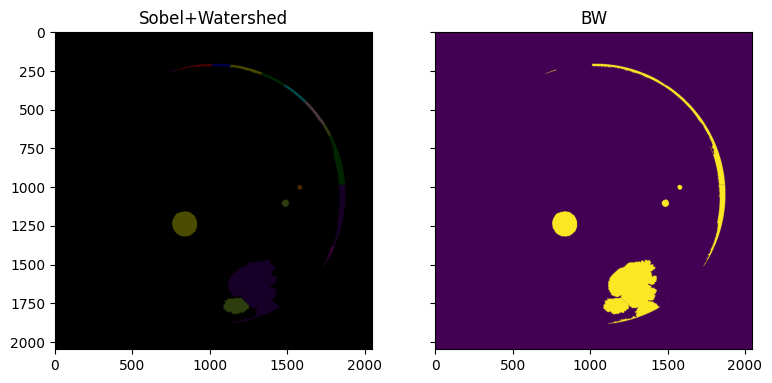

In [ ]:
# compute the Euclidean distance transform
distance = ndi.distance_transform_edt(binary_image)
# identify the local maxima, finding peaks in the Euclidean distance map that are separated by at least 50 pixels, and assigns them a label.
local_max_coords = peak_local_max(distance, min_distance=50, num_peaks_per_label=1)
# create a mask of the local maxima.
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
# label the local maxima.
markers = measure.label(local_max_mask)
segmented_bact = watershed(-distance, markers, mask=binary_image, watershed_line=True)
# convert the segmented image to a binary image.
segmented_bact_BW = np.array((segmented_bact > 1)*1)

# show the segmentations.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
                         sharex=True, sharey=True)

color1 = label2rgb(segmented_bact, image=binary_image, bg_label=0)
axes[0].imshow(color1)
axes[0].set_title('Sobel+Watershed')

axes[1].imshow(segmented_bact_BW)
axes[1].set_title('BW')

#### Extra: Do clustering
An example of how we can work with the data is to perform some clustering on the label regions which could give us information about similar bacteria colonies. Here we use the different features extracted and predified a expected number of clusters, later on we can map the clusters back to the original image for easy visualization.

In [ ]:
# do clustering based on data
features = ['equivalent_diameter', 'eccentricity', 'convex_area',
'mean_intensity']
# data just with features
data = data_label.loc[:,features]

# clusters
n=2
clusters = KMeans(n_clusters=n, random_state=10).fit(data)
d = {'cluster_n':clusters.labels_}
clusters_n = pd.DataFrame(data=d)

# add cluster labels
df_cluster = data_label.join(clusters_n)
df_cluster

,unique_label,label,centroid-0,centroid-1,area,perimeter,equivalent_diameter,eccentricity,convex_area,mean_intensity,cluster_n
0,302_1,1,1005.950993,1576.245033,755.0,103.497475,31.004772,0.416011,784.0,0.987324,1
1,302_2,2,1108.553364,1483.571346,1724.0,153.438600,46.851521,0.206293,1758.0,0.991391,1
2,302_3,3,1241.735346,834.921811,20540.0,543.872150,161.716852,0.188053,20861.0,0.997909,1
3,302_4,4,1666.228395,1271.345194,91447.0,3134.984161,341.224174,0.562432,114009.0,0.956767,0


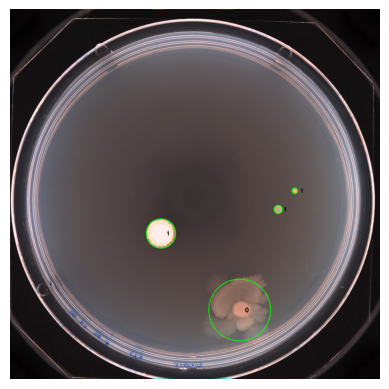

In [ ]:
# make a copy of the image
img = image_color.copy()
for i in range(data_label.shape[0]):
    # draw circle
    cv2.circle(img,(round(df_cluster['centroid-1'][i]), round(df_cluster['centroid-0'][i])), round(df_cluster['equivalent_diameter'][i]/2), (0,255,0), 3)
    # draw text, label
    cv2.putText(img, str(df_cluster['cluster_n'][i]), (round(df_cluster['centroid-1'][i])+30, round(df_cluster['centroid-0'][i])+10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (1, 1, 1), 4)

# new width and height to resize the image
scale = 50
width = int(img.shape[1] * scale/100)
height = int(img.shape[0] * scale/100)

# resizing the image
resized_img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
show_image(resized_img)